### Some Imports

In [9]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

### Add Padding For Block Operation In Edges

In [10]:
def add_padding(padding_size , input):
    columns = input.shape[1]
    rows = input.shape[0]
    output = np.zeros((rows + padding_size * 2, columns + padding_size * 2), dtype=float)
    output[padding_size : rows + padding_size, padding_size : columns + padding_size] = input
    return output

In [11]:
def euclid_dist(a, b):
    distance = np.linalg.norm(a - b)
    return distance

### Searching

In [12]:
def search_bounds(column, block_size, width, rshift):
    disparity_range = 75
    padding = block_size // 2
    right_bound = column
    
    if rshift:
        left_bound = column - disparity_range
        if left_bound < padding:
            left_bound = padding
        step = 1
    else:
        left_bound = column + disparity_range
        if left_bound >= (width - 2 * padding):
            left_bound = width - padding * 2 - 2
        step = -1
    return left_bound, right_bound, step

### Shifting, Block Comparison, Calculate

In [13]:
def get_disparity_map(left, right, block_size, rshift): 
    padding = block_size // 2
    
    right_img = add_padding(padding, right)
    left_img = add_padding(padding, left)
    
    show_image("Right Image With 13px Padding ", right_img)
    show_image("Left Image With 13px Padding ", left_img)

    height, width = left_img.shape

    # disparity_map = np.zeros((height - padding*2, width - padding*2), dtype=float)
    disparity_map = np.zeros(left.shape , dtype=float)

    for row in range(height - block_size + 1):
        for col in range(width - block_size + 1):

            shift = 0
            best_distance_infinity = float('inf')
            
            l_bound, r_bound, step = search_bounds(col, block_size, width, rshift)
            left_pixel = left_img[row:row + block_size, col:col + block_size]

            # for i in range(l_bound, r_bound - padding*2):
            for i in range(l_bound, r_bound, step):
                right_pixel = right_img[row:row + block_size, i:i + block_size]

                if euclid_dist(left_pixel, right_pixel) < best_distance_infinity :
                    ssd = np.sum((left_pixel - right_pixel) ** 2)
                    # print('row:',row,' col:',col,' i:',i,' best_distance:',best_distance_infinity,' shift:',shift,' ssd:',ssd)
                    
                    if ssd < best_distance_infinity:
                        best_distance_infinity = ssd
                        shift = i

            if rshift:
                disparity_map[row, col] = col - shift
            else:
                disparity_map[row, col] = shift - col
            # print('Calculated disparity at ('+str(row)+','+str(col)+') :', disparity_map[row,col])

    return disparity_map

In [14]:
grayscale_max = 255

def show_image(title, image):
    image = np.divide(image, image.max())
    cv2.imwrite('docs/generated_images/' + title + '.jpg', image*grayscale_max)
    
    plt.figure(figsize=(12, 6))
    plt.title(title)
    plt.imshow(image*grayscale_max)
    plt.show()

### Load Images

In [15]:
left_image = cv2.imread('docs/barn2/im0.ppm', cv2.IMREAD_GRAYSCALE)
right_image = cv2.imread('docs/barn2/im1.ppm', cv2.IMREAD_GRAYSCALE)

ground_truth_1 = cv2.imread('docs/barn2/disp2.pgm', cv2.IMREAD_GRAYSCALE)
ground_truth_2 = cv2.imread('docs/barn2/disp6.pgm', cv2.IMREAD_GRAYSCALE)

### Disparity Maps

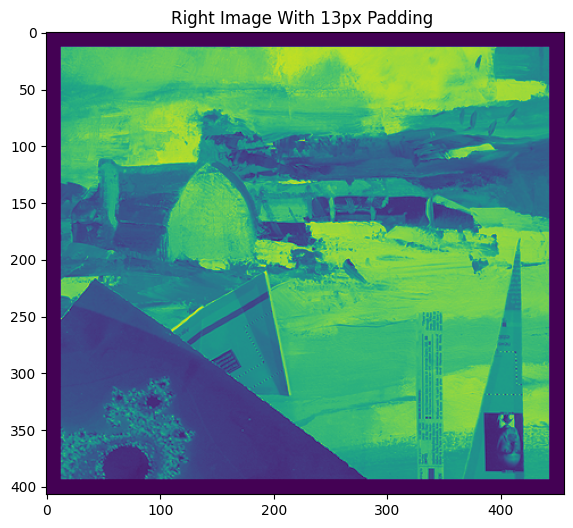

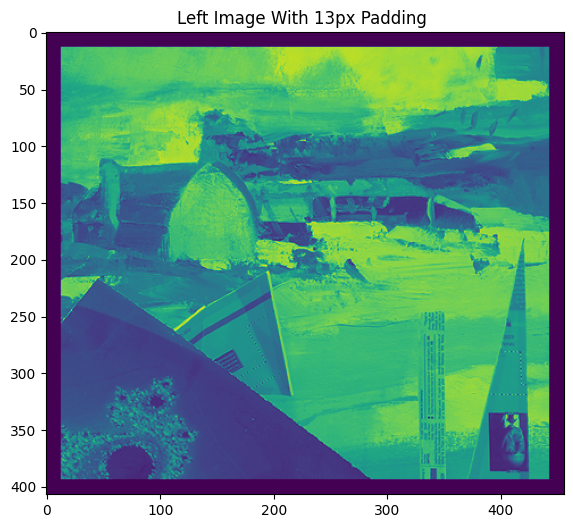

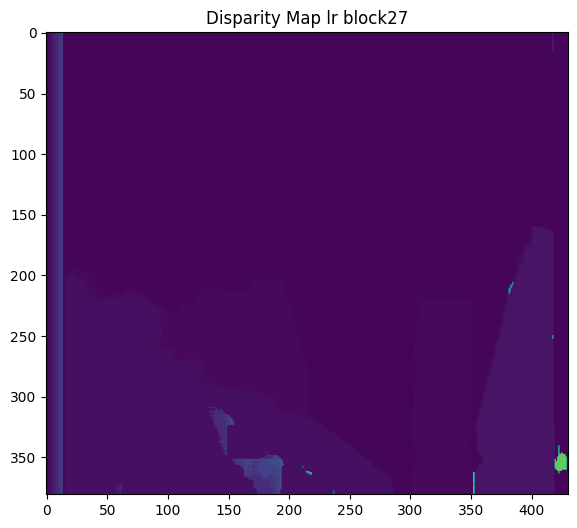

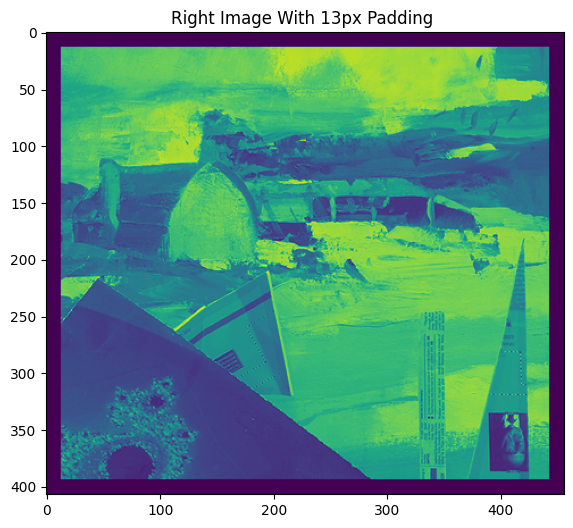

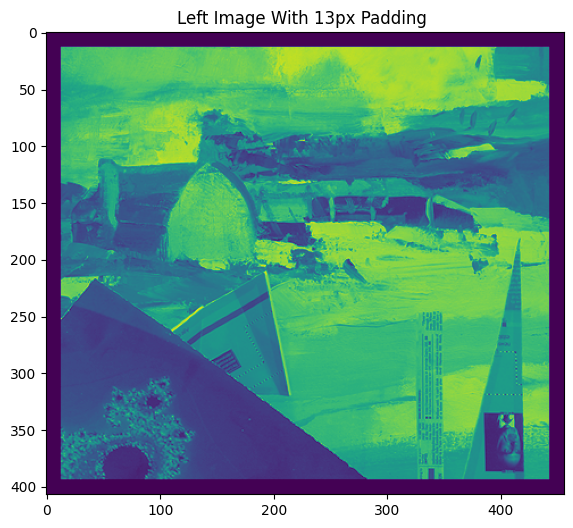

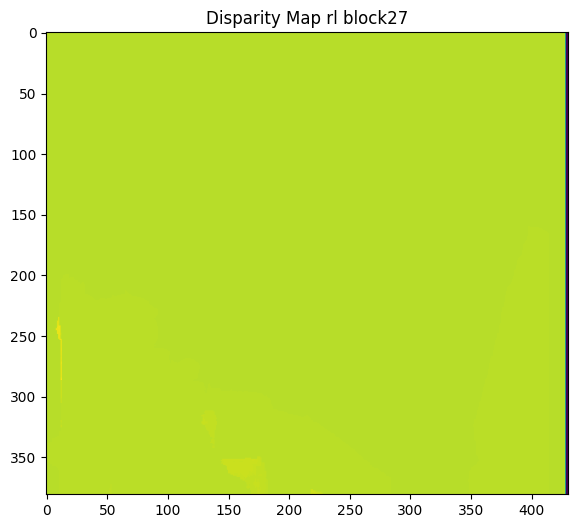

In [16]:
block_size = 27

disparity_map_lr_27 = get_disparity_map(left_image, right_image, block_size, True)
show_image('Disparity Map lr block27', disparity_map_lr_27)

disparity_map_rl_27 = get_disparity_map(right_image, left_image, block_size, False)
show_image('Disparity Map rl block27', disparity_map_rl_27)

### RMSE without Consistency

In [17]:
def mean_square_error(disparity_map, ground_truth):
    mse = np.mean((disparity_map - ground_truth)**2)
    return mse

In [18]:
mse_27_lr = mean_square_error(disparity_map_lr_27, ground_truth_1)
print('RMSE for left-right (block_size=27)', np.sqrt(mse_27_lr))

mse_27_rl = mean_square_error(disparity_map_rl_27, ground_truth_2)
print('RMSE for right-left (block_size=27)', np.sqrt(mse_27_rl))

RMSE for left-right (block_size=27) 53.284250746797234
RMSE for right-left (block_size=27) 61.22323398963955


### RMSE with Consistency Check

In [19]:
def consistency_map_mse_l(d_map_left, d_map_right, left_ground_truth):
    rows, cols = d_map_left.shape
    consistency_map = np.zeros((rows, cols))

    for r in range(rows):
        for c in range(cols):
            left_pixel = d_map_left[r, c]

            if cols > c - left_pixel > 0:
                right_pixel = d_map_right[r, int(c - left_pixel)]
            else:
                right_pixel = d_map_right[r, c]

            if left_pixel == right_pixel:
                consistency_map[r, c] = left_pixel
            else:
                consistency_map[r, c] = 0

    sum = 0
    for r in range(rows):
        for c in range(cols):
            if consistency_map[r, c] != 0:
                sum = sum + (left_ground_truth[r, c] - consistency_map[r, c]) ** 2

    mse_c_left = sum / (rows * cols)
    return mse_c_left, consistency_map

def consistency_map_mse_r(d_map_left, d_map_right, right_ground_truth):
    rows, cols = d_map_right.shape
    consistency_map = np.zeros((rows, cols))

    for r in range(rows):
        for c in range(cols):
            right_pixel = d_map_right[r, c]

            if c + right_pixel < cols:
                left_pixel = d_map_left[r, int(c + right_pixel)]
            else:
                left_pixel = d_map_left[r, c]

            if right_pixel == left_pixel:
                consistency_map[r, c] = right_pixel
            else:
                consistency_map[r, c] = 0

    sum = 0
    for r in range(rows):
        for c in range(cols):
            if consistency_map[r, c] != 0:
                sum = sum + (right_ground_truth[r, c] - consistency_map[r, c]) ** 2

    mse_c_right = sum / (rows * cols)
    return mse_c_right, consistency_map

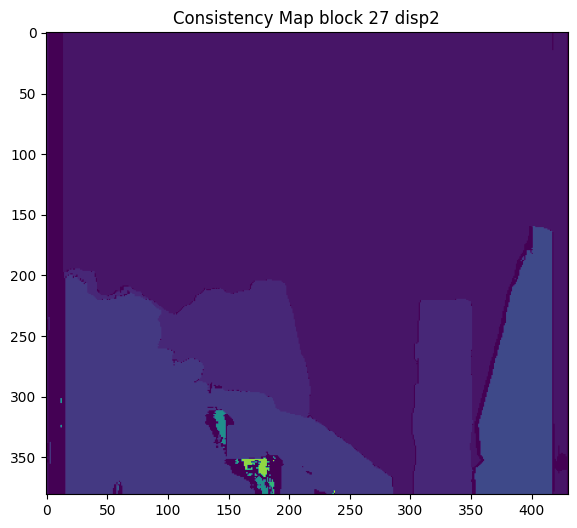

RMSE for disp2 (block_size=27) after Consistency check: 51.28792009553811


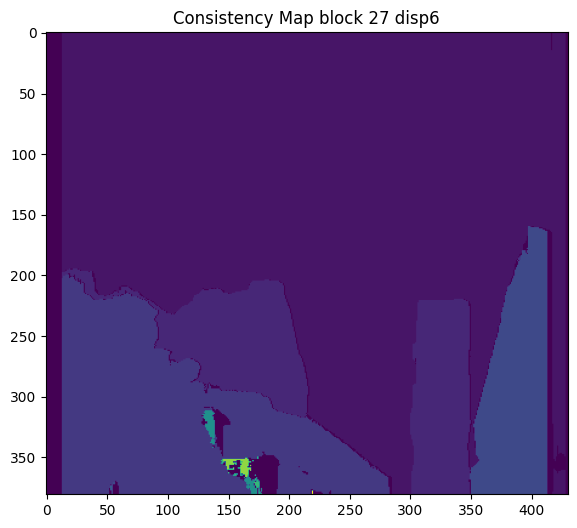

RMSE for disp6 (block_size=27) after Consistency check:  50.491453621857595


In [20]:
mse_27c_left, cconsistency_map_27l = consistency_map_mse_l(disparity_map_lr_27, disparity_map_rl_27, ground_truth_1)
show_image('Consistency Map block 27 disp2', cconsistency_map_27l)
print('RMSE for disp2 (block_size=27) after Consistency check:', np.sqrt(mse_27c_left))

mse_27c_right, cconsistency_map_27r = consistency_map_mse_r(disparity_map_lr_27, disparity_map_rl_27, ground_truth_2)
show_image('Consistency Map block 27 disp6', cconsistency_map_27r)
print('RMSE for disp6 (block_size=27) after Consistency check: ', np.sqrt(mse_27c_right))